# Overview


This script walks you through training a support vector machine (SVM) classifier on an existing single-cell dataset with trustworthy annotations for use in predicting cell types in other single-cell like datasets (including spatial transcriptomics). The inspiration comes from these papers that highlight SVM outperforming other annotation methods.
- https://doi.org/10.1093/bib/bbae392
- https://doi.org/10.1186/s13059-019-1795-z
- https://doi.org/10.1093/bib/bbac561

This method is intended to be relatively fast (< several hours) and generalizeable, but it will not be perfect. The results should be corroborated with other methods such as marker gene expression to confirm results. 

A few brief notes on this script:


It uses `pyprojroot`'s `here` functionality to handle relative paths based on project directory structure. If you are not familiar with this type of project organization, you can replace these path designations with other `os.Path` objects.


Accessory functions for plots are kept in a separate script to keep this notebook cleaner.

In [ ]:
from pyprojroot import here
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
## In-house package available on pypi, install with `pip install FHIL_python_utils`
from FHIL_python_utils import svm
from FHIL_python_utils.plotting import confusionMatrix

## You dont need to load this module, but it must be installed to map ens IDs to gene symbols
## import pybiomart
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

ModuleNotFoundError: No module named 'pyprojroot'

# Load reference data

This notebook will not have a deep dive on selecting reference data, however this is the most influential step. You should try to find reference data that has 
- High quality annotations for your celltypes of interest
    - from a reputable lab, atlas, high impact paper, etc.
- Sample conditions similar to your query data
    - Organism, tissue, disease
- Large amounts of data 
    - Both cells and genes. Ideally 1k+ cells per celltype, and ideally a full transcriptome capture (e.g. not panels) to ensure high overlap with your query sample. However, if you can find data with a matching gene panel to your query data, that should be fine.

[Cellxgene](https://cellxgene.cziscience.com/datasets) has several thousand datasets with great querying and 1-step downloads to access annotated h5ad objects ready for this method. 

Assuming you have an h5ad object with some cell annotations, proceed with loading it here.

In [13]:
ref_data = sc.read_h5ad(here('02_data/03_processed-data/cellxgene_reference.h5ad'))
## Make unique names to avoid collisions with later functions
ref_data.var_names_make_unique()
ref_data.obs_names_make_unique()

Some publications have cell annotnations in csv files or other formats otherwise not stored in the h5ad object. If needed, you can do something like the code below to merge an external set of annotations with your ref data. Be mindfull that if the references are separated like this, you may need to subset the ref data for cells that are annotated / survived filtering, as the h5ad may just be raw data. 

In [ ]:
# sc_annotations = pd.read_csv(os.path.join(here('02_data/01_raw-data/5000_genes/sc/FLEX_Ovarian_Barcode_Cluster_Annotation.csv')))
# ref_data.obs = pd.merge(
#     ref_data.obs,
#     sc_annotations, 
#     left_index=True,
#     right_on='Barcode',
#     how='left'
# ).set_index('Barcode')

## Map gene IDs to symbols

If your object's features are ensembl IDs and you want them as gene symbols, you can convert them with `pybiomart` (may require separate installation). You can skip this section if it's not needed.

In [14]:
ref_data.var.index

Index(['ENSG00000243485', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000236601', 'ENSG00000229905',
       'ENSG00000237491', 'ENSG00000177757', 'ENSG00000225880',
       'ENSG00000230368',
       ...
       'ENSG00000276017', 'ENSG00000278817', 'ENSG00000277196',
       'ENSG00000278384', 'ENSG00000278633', 'ENSG00000276345',
       'ENSG00000277856', 'ENSG00000275063', 'ENSG00000271254',
       'ENSG00000277475'],
      dtype='object', length=28421)

In [15]:

annot = (
    sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", 'external_gene_name'],
    ).set_index("ensembl_gene_id")
    .query('external_gene_name.notna()')
)
print(f'{len([x for x in ref_data.var.index if x in annot.index])} of {len(ref_data.var.index)} genes have annotations')

22651 of 28421 genes have annotations


In [16]:
# subset the ref data
ref_data = ref_data[:, [x for x in ref_data.var.index if x in annot.index]]
# add the pybiomart gene symbols as the var index
ref_data.var = (
    pd.merge(
        ref_data.var.reset_index(names='ens_id'),  # move index to 'ens_id'
        annot,
        left_on='ens_id',
        right_index=True,
        how='left'
    )
    .set_index('external_gene_name')  # make gene names the new index
)
# Again, ensure unique symbols/indices
ref_data.var_names_make_unique()
ref_data.var

,ens_id,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
external_gene_name,,,,,,,
MIR1302-2HG,ENSG00000243485,True,MIR1302-2HG,NCBITaxon:9606,gene,623,lncRNA
LINC01409,ENSG00000237491,True,LINC01409,NCBITaxon:9606,gene,1059,lncRNA
FAM87B,ENSG00000177757,True,FAM87B,NCBITaxon:9606,gene,1947,lncRNA
LINC00115,ENSG00000225880,True,LINC00115,NCBITaxon:9606,gene,3312,lncRNA
FAM41C,ENSG00000230368,True,FAM41C,NCBITaxon:9606,gene,504,lncRNA
...,...,...,...,...,...,...,...
MT-ND4,ENSG00000198886,False,MT-ND4,NCBITaxon:9606,gene,1378,protein_coding
MT-ND5,ENSG00000198786,False,MT-ND5,NCBITaxon:9606,gene,1812,protein_coding
MT-ND6,ENSG00000198695,False,MT-ND6,NCBITaxon:9606,gene,525,protein_coding


## Check annotations

In [17]:
# If necessary, rename annotations for consistency downstream
# This renames any column (e.g. 'cell_type' as 'annotations')
if 'annotations' not in ref_data.obs.columns.values:
    ref_data.obs.rename(columns={'cell_type': 'annotations'}, inplace=True)

Review the counts of cells. Are there classifications that are over or under-represented? You should probably filter out celltypes with <100 observations (ideally, <500). You may also want to downsample the data for ease of training, as each observation contributes exponentially to training time. You probably won't benefit from more than 5,000 or 10,000 cells of a given type. 

It's worth thinking about whether class imbalances should be adjusted for through downsampling. My uninformed take is that you should maintain the class imbalances as they occur. Artificially balancing the query data may give false confidence to less abundant celltype predictions. But this should be investigated further. 

In [18]:
ref_data.obs.annotations.value_counts()

annotations
keratinocyte                            53844
endothelial cell of vascular tree       25785
helper T cell                           20617
skin fibroblast                         17456
Langerhans cell                         12545
monocyte-derived dendritic cell         12490
macrophage                              12117
cytotoxic T cell                         8680
innate lymphoid cell                     6033
regulatory T cell                        5743
pericyte                                 5006
endothelial cell of lymphatic vessel     4924
melanocyte                               3682
dendritic cell                           2804
inflammatory macrophage                  1773
natural killer cell                       739
conventional dendritic cell               604
mast cell                                 557
Schwann cell                              269
plasma cell                                71
Name: count, dtype: int64

In [65]:
# Remove unannotated data or subset for specific metadata values
ref_data_filtered = ref_data[(
    ~ref_data.obs['annotations'].isna() &
    ~ref_data.obs['annotations'].isin(['unknown'])
),:]
# Subset cells
sc.pp.sample(ref_data_filtered, n=50000)
ref_data_filtered.obs['annotations'].value_counts()

annotations
keratinocyte                            13814
endothelial cell of vascular tree        6694
helper T cell                            5259
skin fibroblast                          4405
monocyte-derived dendritic cell          3210
Langerhans cell                          3154
macrophage                               3066
cytotoxic T cell                         2254
innate lymphoid cell                     1538
regulatory T cell                        1434
endothelial cell of lymphatic vessel     1275
pericyte                                 1245
melanocyte                                936
dendritic cell                            705
inflammatory macrophage                   427
natural killer cell                       203
mast cell                                 152
conventional dendritic cell               143
Schwann cell                               64
plasma cell                                22
Name: count, dtype: int64

You may want to map the annotation labels to new values, for consistency with your study / understanding.

In [ ]:
# mapping_dict = {
#     'cytotoxic t-cell': 'CD8+ T',
#     'NKT': 'NK'
# }
# ref_data_filtered.obs['original_annotations'] = ref_data_filtered.obs['annotations']
# ref_data_filtered.obs['annotations'] = ref_data_filtered.obs['original_annotations'].astype(str).map(mapping_dict)

## Preprocess

Ensure the data is normalized and scaled in a manner consistent with the query data. If you applied a different normalization method, you should add that here, or re-process your query data with this simple workflow to ensure consistency between the two.

In [28]:
sc.pp.normalize_total(ref_data_filtered, target_sum=1e4)
sc.pp.log1p(ref_data_filtered)

# Load query data

In [30]:
query_data = sc.read_h5ad(here('02_data/03_processed-data/gvhd-broad.h5ad'))

/fh/fast/_IRC/FHIL/grp/bioinfo_tools/analysis_templates/analysis_project_template/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


This workflow assumes your query data is pre-filtered & quality checked. It may also be pre-processed, but we will check that now.

In [31]:
sc.pp.normalize_total(query_data, target_sum=1e4)
sc.pp.log1p(query_data)

## Over clustering


We will over-cluster the query data for consensus annotation. Consensus annotation just takes the most abundant/probable annotations across a group of cells and applies them to all cells in the cluster. This helps handle dropout and noise with key genes used to predict celltype. You could use existing clusters for this step, but it's likely that the granularity of clustering used for visualization / descriptive analyses of the query data is lower than the level desireable for cluster consensus annotation: smaller clusters (to a point) are preferred for this approach. Ideally, you annotate at the level of several hundred cells per cluster. In practice, this may be difficult or overkill. Aim for at least 50 clusters.


In [ ]:
sc.pp.highly_variable_genes(query_data)
sc.pp.pca(query_data)
sc.pp.neighbors(query_data)

In [39]:
## The resolution parameter of Leiden doesn't directly translate to an
##  expected cell count, so you may need to adjust this value to produce
##  the desired number of clusters
resolution = np.round(np.log10(query_data.n_obs))
print(f"Over-clustering input data with resolution set to {resolution}")
sc.tl.leiden(query_data, resolution=resolution, key_added='over_clustering', flavor = 'igraph', n_iterations = 2)

Over-clustering input data with resolution set to 5.0


Check if you are getting enough clusters and that they are balanced. You should see a relatively linear descending line here, indicating there aren't many clusters with few cells.

<Axes: xlabel='over_clustering'>

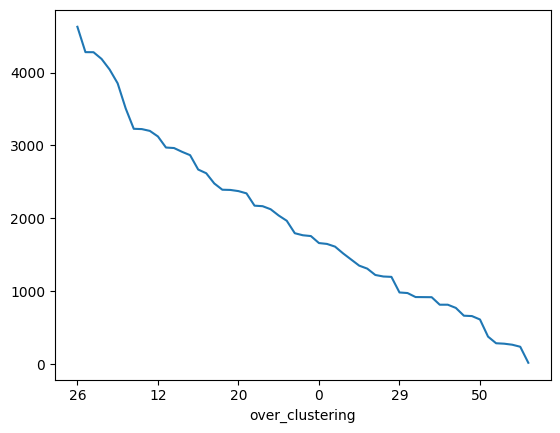

In [40]:
query_data.obs['over_clustering'].value_counts().plot()

# Feature selection

Now we select the genes/features that will be used to train the model and predict celltypes in our query data. There are a few considerations to motivate using fewer features:
- More genes = more run/train time (O(n))
- Variable features not useful for distinguishing celltype may confound classification

However, the model will weight features based on their classification utility, so we don't have to select the 'perfect' list. The features used must be present in both the query and the reference dataset. For datasets with small numbers of features (e.g. 500 gene panels), we probably want to use as many genes as we can.

In [70]:
ref_feats = set(ref_data_filtered.var.index.to_list())
query_feats = set(query_data.var.index.to_list())
query_feats_in_ref = query_feats.intersection(ref_feats)
ref_feats_in_query = ref_feats.intersection(query_feats)

In [71]:
print(
    f"""
    {len(query_feats)} in the query data, of which {len(query_feats_in_ref)} are found in the training data.
    {len(ref_feats)} in the training data, of which {len(ref_feats_in_query)} are found in the query data.
    """
)


    539 in the query data, of which 367 are found in the training data.
    367 in the training data, of which 367 are found in the query data.
    


If you're working with a small gene panel and you see a fair number of genes missing from the training data, you may want to review the missing set to see if there are crucial genes absent. With Xenium data for instance, it's often just a set of negative probes/controls that are not interesting. 

In [43]:
# [x for x in query_data.var.index.to_list() if x not in ref_data.var.index.to_list()]

['FAM49A',
 'NegControlCodeword_0502',
 'NegControlProbe_00033',
 'BLANK_0030',
 'NegControlProbe_00022',
 'NegControlProbe_00012',
 'NegControlCodeword_0520',
 'BLANK_0367',
 'LARS',
 'BLANK_0122',
 'BLANK_0372',
 'BLANK_0382',
 'NegControlCodeword_0516',
 'BLANK_0380',
 'BLANK_0369',
 'BLANK_0402',
 'BLANK_0223',
 'BLANK_0253',
 'NegControlCodeword_0538',
 'KARS',
 'NegControlCodeword_0536',
 'ATXN3L',
 'NegControlProbe_00014',
 'BLANK_0453',
 'CLECL1',
 'GRASP',
 'OR2AK2',
 'BLANK_0429',
 'NegControlProbe_00042',
 'BLANK_0381',
 'NegControlCodeword_0506',
 'BLANK_0273',
 'BLANK_0440',
 'NegControlCodeword_0514',
 'NegControlCodeword_0521',
 'BLANK_0481',
 'BLANK_0221',
 'NegControlCodeword_0525',
 'BLANK_0303',
 'KRTAP15-1',
 'BLANK_0386',
 'NegControlCodeword_0507',
 'QARS',
 'NegControlCodeword_0533',
 'NegControlCodeword_0510',
 'NegControlCodeword_0540',
 'NegControlProbe_00009',
 'NegControlProbe_00013',
 'BLANK_0422',
 'BLANK_0379',
 'BLANK_0181',
 'NegControlCodeword_0534',
 

Alternatively, if you have thousands of genes overlapping, you may want to subset to informative features to reduce the training burden. 

In [ ]:
sc.pp.highly_variable_genes(query_data)
sc.pp.highly_variable_genes(ref_data_filtered)

In [68]:
ref_hvgs = set(ref_data_filtered.var[ref_data_filtered.var['highly_variable']].index.to_list())
query_hvgs = set(query_data.var[query_data.var['highly_variable']].index.to_list())
query_hvgs_in_ref = query_hvgs.intersection(ref_feats)
ref_hvgs_in_query = ref_hvgs.intersection(query_feats)
shared_hvgs = query_hvgs.intersection(ref_hvgs)

In [69]:
print(
    f"""
    {len(query_hvgs)} HVGs in the query data, of which {len(query_hvgs_in_ref)} are found in the training data.
    {len(ref_hvgs)} HVGs in the training data, of which {len(ref_hvgs_in_query)} are found in the query data.
    {len(shared_hvgs)} shared HVGs.
    """
)


    118 HVGs in the query data, of which 70 are found in the training data.
    84 HVGs in the training data, of which 84 are found in the query data.
    24 shared HVGs.
    


Use some interesection of genes present in both datasets to define your training set here. 

In [72]:
training_genes = query_feats_in_ref # shared_hvgs
all([
    all([x in ref_data_filtered.var.index.to_list() for x in training_genes]),
    all([x in query_data.var.index.to_list() for x in training_genes])
])

True

In [73]:
len(training_genes)

367

## Subset for selected features

In [66]:
ref_data_filtered = ref_data_filtered[:, list(training_genes)]
ref_data_filtered

View of AnnData object with n_obs × n_vars = 50000 × 367
    obs: 'sample_id', 'Status', 'Site', 'Location', 'donor_id', 'full_clustering', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'annotations', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'ens_id', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Status_colors', 'citation', 'default_embedding', 'dendrogram_leiden', 'full_clustering_colors', 'leiden', 'neighbors', 'organism', 'organism_ontology_term_id', 'pca', 'rank_genes_groups', 'schema_reference', 'schema_version', 'title', 'hvg'
    obsm: 'X_pca', 'X_um

In [67]:
query_data_filtered = query_data[:, list(training_genes)]
query_data_filtered

View of AnnData object with n_obs × n_vars = 111013 × 367
    obs: 'cell', 'centroid_x', 'centroid_y', 'centroid_z', 'cluster', 'volume', 'population', 'filename', 'leiden', 'celltype', 'over_clustering'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'over_clustering', 'hvg'
    obsm: 'Xumap', 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# SVM

Making a rudimentary SVM with a linear kernel. This assumes the input data will be normalized and log scaled. StandardScaler will ensure the data is scaled when input to the model. We do this in a pipeline rather than scaling the data itself to avoid expensive conversions and storage of the scaled matrix and to make the pipeline more universal. In practice, the normalization and log transformation should probably also be added to this pipeline, but as they are useful in the previous steps for clustering and feature selection, we will leverage the previous work. 

A quick explanation of the parameters here:
- **with_mean=False**: to avoid conversion for sparse matrices
- **kernel='linear'**: Linear kernels are much faster and easier to interpret than say 'RBF', and perform adequately/better for the data we're working with
- **probability=True**: adds to runtime, but uses sampling to provide probability estiamtes for each prediction class
- **random_state**: For reproducibility
- **cache_size**: memory available for each training session. Increasing it should speed up training time. Default is 200Mb.

In [74]:
pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    SVC(kernel='linear', probability=True, random_state=42, cache_size=1000) 
)

## Split test/train


Seeing how your model performs on itself can be a good indicator of the quality of the reference data, and can be used to select the optimal value of C for this dataset.

In [75]:
num_cells = ref_data_filtered.n_obs
test_ratio = 0.2
## 20% for testing
test_indices = np.random.choice(num_cells, size=int(num_cells * test_ratio), replace=False)
train_indices = np.array([i for i in range(num_cells) if i not in test_indices])

ref_data_filtered_train = ref_data_filtered[train_indices, :].copy()
ref_data_filtered_test = ref_data_filtered[test_indices, :].copy()

## Grid search C param

Performing n-fold cross-validation on training data to determine the best value for C. The default value is 1. Smaller values of C can improve accuracy, at the cost of increased runtime. This may take some time depending on the number of jobs, folds, cells, features and classes. The choice and importance of C depend on the regularization.

While in theory L1 regularization seems useful for feature selection, in practice we are pre-selecting features using highly variable feature algorithms, and [L2 regularization is almost always preferred to L1 regularization](https://www.csie.ntu.edu.tw/~cjlin/liblinear/FAQ.html#l1_regularized_classification). For L2 regularization, [the value of C is less impactful on model performance](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py), so we probably don't need to spend too much effort optimizing C. If this is being really slow, you can feel decent about using the default value of C = 1 to move forward. 

In [ ]:
## This will be the slowest thing in this script.
##  It may take several hours depending on the size of the input data
##  and your machine.
grid_search = GridSearchCV(
    pipeline,
    {'svc__C': [0.001, 0.01, 0.1, 1, 10]}, 
    cv=5, # 5-fold
    scoring='f1_micro',  # or 'f1_macro', etc.
    n_jobs=-1,
    verbose=2
)
## Assumes your normalized/log transformed data is in 'X' and your annotations in 'annotations'
grid_search.fit(ref_data_filtered_train.X, ref_data_filtered_train.obs['annotations'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svc__C': [0.0001, 0.001, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


Inspect the grid search results. Does a smaller C (more regularization) provide significantly better test scores (see the columns at the end)? Is the increase in runtime worth the tradeoff? You could consider exploring more values of C here if motivated. 

In [77]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,338.339922,1.767259,22.448235,0.127672,0.0001,{'svc__C': 0.0001},0.921125,0.918375,0.923000,0.921000,0.922375,0.921175,0.001590,6
1,110.097953,0.707789,12.106119,0.038430,0.0010,{'svc__C': 0.001},0.946000,0.947125,0.950000,0.946375,0.950500,0.948000,0.001879,3
2,61.513961,0.516222,8.659279,0.026421,0.0100,{'svc__C': 0.01},0.951125,0.952250,0.954125,0.952125,0.956125,0.953150,0.001776,1
3,59.813909,0.852432,7.731297,0.060960,0.1000,{'svc__C': 0.1},0.947000,0.947375,0.949750,0.947250,0.951000,0.948475,0.001605,2
4,84.393790,1.703701,7.542713,0.109755,1.0000,{'svc__C': 1},0.945750,0.944500,0.947375,0.941500,0.946000,0.945025,0.001985,4
5,285.986209,6.864439,7.431693,0.076135,10.0000,{'svc__C': 10},0.942625,0.942500,0.943500,0.940125,0.943375,0.942425,0.001216,5


In [78]:
model = grid_search.best_estimator_
# Store gene names
model['svc'].feature_names_in_ = np.array(ref_data_filtered_train.var_names.to_list())

## Evaluate model on test data

Note that the [highest probability class will not necessarily correspond to the output of `model.predict`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict_proba) due to randomness in sampling used to create the probability, so be careful of expecting exact concordance between `predict_proba` and `predict` outputs. 

In [79]:
probs = model.predict_proba(ref_data_filtered_test.X)

/fh/fast/_IRC/FHIL/grp/bioinfo_tools/analysis_templates/analysis_project_template/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


It may be interesting to look at the genes that are being used to distinguish classes. Do they look familiar?

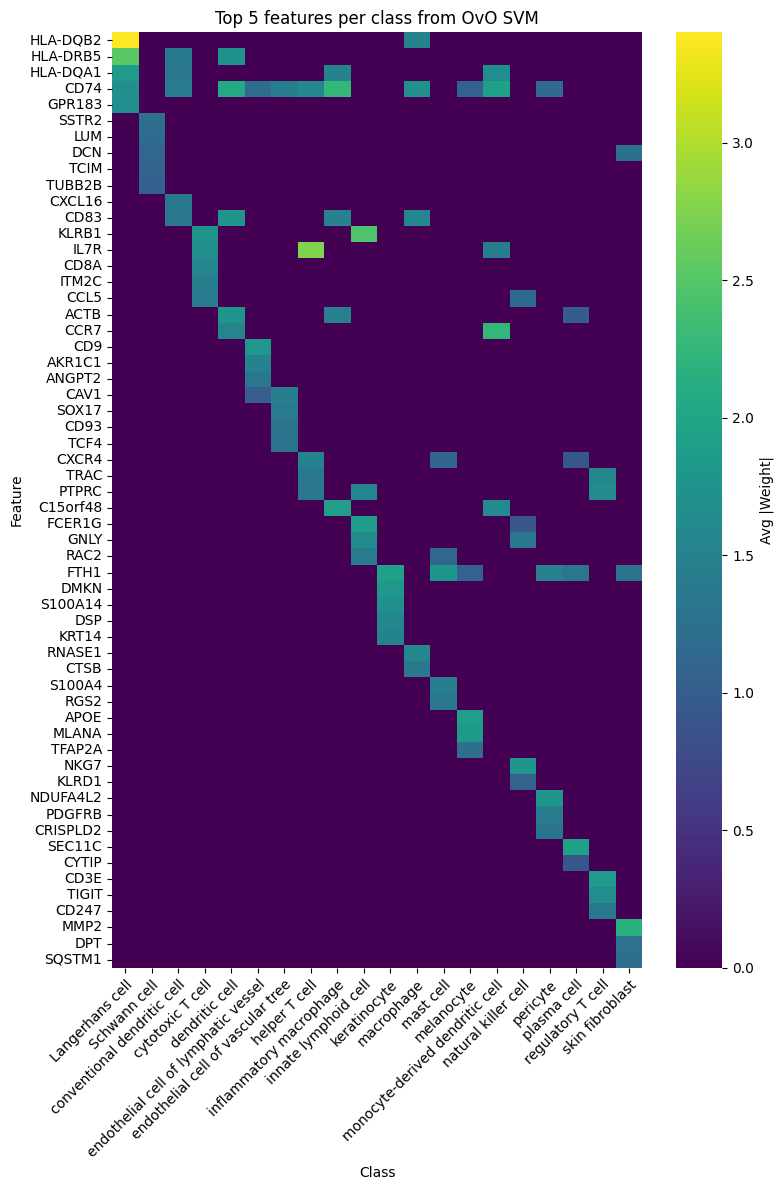

In [ ]:
## plot from in-house package
FHIL_python_utils.svm.featureWeightHeatmap(model)

## Save model

It's lightweight to write to disk and you don't want to wait for that to train again

In [89]:
with open(here('03_analysis/04_checkpoints/annotation_svm_model.pkl'), 'wb') as fo:
    pickle.dump(model, fo)

# Predict query annotations

In [91]:
pred_probability = model.predict_proba(query_data_filtered.X)

/fh/fast/_IRC/FHIL/grp/bioinfo_tools/analysis_templates/analysis_project_template/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Rather than just taking the top predicted class, we will apply a minimum threshold for classification, below which a cell will be considered 'undetermined'. I also like to consider if there is another class with similarly high probability. This can indicate model confusion *or* may show two closely related classes that are actually very similar, allowing you to designate a more appropriately broad classification. 

For example, memory T cell subsets are notoriously hard to split. A cell may have intermediate probability for both 'central' and 'effector' memory T cell, which you could more confidently assign just 'cm/em T cell' or refine with specific marker genes.

In [92]:
threshold = 0.5      # Minimum required confidence
margin = 0.05        # Allow second-best class if within this range of the top

pred_classes = []
pred_classes_simplified = []
for probs in pred_probability:
    top_idx = np.argmax(probs)
    top_prob = probs[top_idx]

    # Mask out top index to find second-best
    second_idx = np.argsort(probs)[-2]
    second_prob = probs[second_idx]

    if top_prob < threshold:
        pred_classes.append('unknown')
        pred_classes_simplified.append('unknown')
    elif (top_prob - second_prob) <= margin:
        pred_classes.append(f"{model.classes_[top_idx]} | {model.classes_[second_idx]}")
        pred_classes_simplified.append('mixed')
    else:
        pred_classes.append(model.classes_[top_idx])
        pred_classes_simplified.append(model.classes_[top_idx])
pd.Series(pred_classes).value_counts()
## or, you may just prefer the non-merged classes
pd.Series(pred_classes_simplified).value_counts()

skin fibroblast                         35709
keratinocyte                            26568
macrophage                              14427
unknown                                  9192
Schwann cell                             8370
endothelial cell of vascular tree        5196
cytotoxic T cell                         3449
pericyte                                 2769
regulatory T cell                        1473
endothelial cell of lymphatic vessel     1345
melanocyte                               1088
natural killer cell                       441
plasma cell                               352
mixed                                     173
innate lymphoid cell                      156
conventional dendritic cell               120
helper T cell                              85
mast cell                                  46
Langerhans cell                            32
dendritic cell                             19
monocyte-derived dendritic cell             2
inflammatory macrophage           

In [112]:
query_data_filtered.obs['svm_predicted_class'] = pd.Categorical(pred_classes)
query_data_filtered.obs['svm_predicted_class_simplified'] = pd.Categorical(pred_classes_simplified)

## Cluster consensus annotation

Now we can aggregate predictions over small groups of cells to smooth the signal. With this setup, a cluster that has more than `proportion_thresh` of it's cells with a single label will cause all cells in that cluster to adopt that label. Optionally, you can use the same 'top 2' method as before to possibly retain useful model confusion for further review. Let's first look and see if most of the clusters are dominated by a single class.

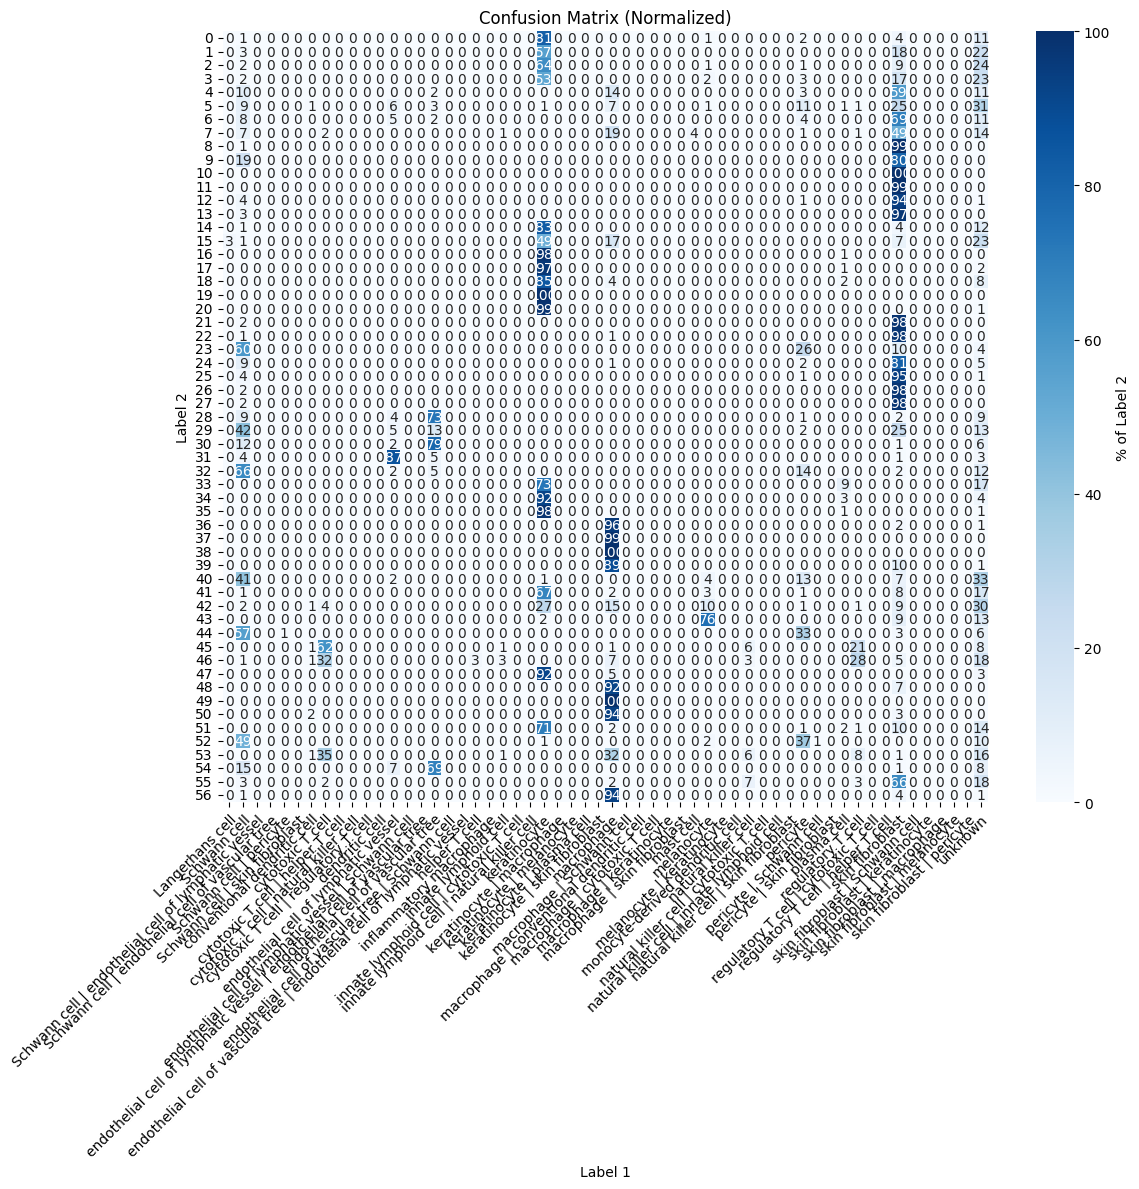

In [ ]:
confusionMatrix(query_data_filtered.obs['svm_predicted_class'], query_data_filtered.obs['over_clustering'], normalize=True, figsize=(12,12))

What you see here may inform how strict your thresholds should be.

In [106]:
proportion_thresh = 0.5
margin = 0.15  # max difference between top1 and top2 to consider combining
group_by = 'over_clustering'#'over_clustering'
assigned_labels = {}

plotdata = (
    query_data_filtered.obs.groupby(group_by)['svm_predicted_class']
    .value_counts(normalize=True)
    .groupby(level=0)
    .head(2)
    .reset_index(name='count')
)

for group, group_df in plotdata.groupby(group_by):
    top_values = group_df.sort_values('count', ascending=False).reset_index(drop=True)
    top1 = top_values.loc[0]

    if top1['count'] >= proportion_thresh:
        assigned_labels[group] = top1['svm_predicted_class']

    elif len(top_values) > 1:
        top2 = top_values.loc[1]

        # Check margin condition
        if abs(top1['count'] - top2['count']) <= margin and 'unknown' not in {top1['svm_predicted_class'], top2['svm_predicted_class']}:
            values = sorted([top1['svm_predicted_class'], top2['svm_predicted_class']])
            assigned_labels[group] = f"{values[0]} | {values[1]}"
        else:
            assigned_labels[group] = 'unknown'

    else:
        assigned_labels[group] = 'unknown'


/loc/scratch/29265947/ipykernel_29811/2415183249.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  query_data.obs.groupby(group_by)['svm_predicted_class']
/loc/scratch/29265947/ipykernel_29811/2415183249.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)
/loc/scratch/29265947/ipykernel_29811/2415183249.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, group_df in plotdata.groupby(group_

In [107]:
query_data_filtered.obs['overclustering_consensus_annotation'] = query_data_filtered.obs[group_by].map(assigned_labels)

How many cells are called as each class? Was the model able to annotate most cells?

In [108]:
query_data_filtered.obs['overclustering_consensus_annotation'].value_counts()

overclustering_consensus_annotation
skin fibroblast                         34370
keratinocyte                            32696
macrophage                              12818
unknown                                  8927
endothelial cell of vascular tree        6270
Schwann cell                             6006
cytotoxic T cell                         2913
cytotoxic T cell | macrophage            2343
cytotoxic T cell | regulatory T cell     2167
endothelial cell of lymphatic vessel      920
Schwann cell | pericyte                   919
melanocyte                                664
Name: count, dtype: int64

It might be interesting to look at the calls in a umap

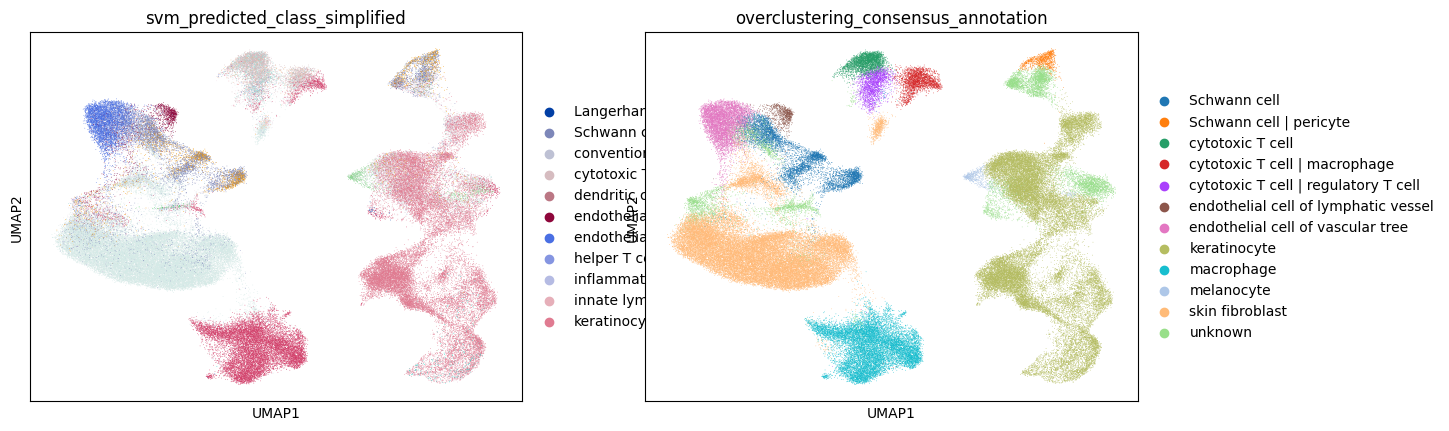

In [ ]:
# sc.tl.umap(query_data_filtered)
sc.pl.umap(query_data_filtered, color=['svm_predicted_class_simplified', 'overclustering_consensus_annotation']) #,legend_loc="on data", legend_fontsize=6)

# Next steps

You should corroborate the SVM annotations with evidence from literature supported marker genes. Consider the SVM approach a first pass to help you narrow down likely outcomes, but ultimately you should look to confirm them with cannonical markers. [Cellxgene](https://cellxgene.cziscience.com/cellguide) has a nice resource for finding 'cannonical' and 'computationally derived' marker genes for many celltypes. 

You may also want to subset out groups of cells that were tricky to annotate or need further refinement. For example, you may subset out your T cells and try to find an isolated T cell reference set to repeat this process. By subsetting specific cells, you may be able to leverage a broader set of reference datasets than you could on your whole query set. There are many lymphoctes that may be useful for your T cells even if they aren't from the same tissue or disease state.  

# Marker genes

You should review marker genes for cell clusters. Are they consistent with the annotations? You may want to work with a smaller set of clusters than the 'overclustering' results for simplicity. 

In [117]:
sc.tl.leiden(query_data_filtered, resolution=1, key_added='leiden', flavor = 'igraph', n_iterations = 2)

In [119]:
# Obtain cluster-specific differentially expressed genes
group_by = 'leiden'
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.tl.rank_genes_groups(query_data_filtered, groupby=group_by, method="wilcoxon")
sc.tl.filter_rank_genes_groups(query_data_filtered, min_in_group_fraction=0.25, max_out_group_fraction=1, min_fold_change=0.75)
cluster_markers = {}
for x in query_data_filtered.obs[group_by].cat.categories:
    marker_genes = sc.get.rank_genes_groups_df(query_data_filtered, group=x, key='rank_genes_groups_filtered')
    marker_genes = marker_genes[~pd.isna(marker_genes['names'])]['names'].tolist()
    cluster_markers[x] = marker_genes

In [121]:
cluster_markers

## Subsetting

Make a copy of the script and do it again!

In [122]:
## data_subset = query_data_filtered[query_data_filtered.obs['overclustering_consensus_annotation'] == 'keratinocyte', :]
## data_subset.write()

## Edit annotation names

You may want to map predicted classes or specific clusters to a custom name

In [134]:
values_to_map = pd.Series(query_data_filtered.obs['overclustering_consensus_annotation'].unique(), dtype='str')
mapping_dict = dict(zip(
    values_to_map,
    np.where(
        values_to_map.str.contains('|', regex=False),
        'unknown',
        values_to_map
    )
))
## be careful about the order of 'unique()'
mapping_dict


{'keratinocyte': 'keratinocyte',
 'skin fibroblast': 'skin fibroblast',
 'unknown': 'unknown',
 'endothelial cell of lymphatic vessel': 'endothelial cell of lymphatic vessel',
 'macrophage': 'macrophage',
 'endothelial cell of vascular tree': 'endothelial cell of vascular tree',
 'Schwann cell': 'Schwann cell',
 'melanocyte': 'melanocyte',
 'cytotoxic T cell': 'cytotoxic T cell',
 'cytotoxic T cell | regulatory T cell': 'unknown',
 'cytotoxic T cell | macrophage': 'unknown',
 'Schwann cell | pericyte': 'unknown'}

In [135]:
query_data_filtered.obs['annotations'] = query_data_filtered.obs['overclustering_consensus_annotation'].astype(str).map(mapping_dict)

# Save

In [147]:
save_data

,Langerhans cell,Schwann cell,conventional dendritic cell,cytotoxic T cell,dendritic cell,endothelial cell of lymphatic vessel,endothelial cell of vascular tree,helper T cell,inflammatory macrophage,innate lymphoid cell,keratinocyte,macrophage,mast cell,melanocyte,monocyte-derived dendritic cell,natural killer cell,pericyte,plasma cell,regulatory T cell,skin fibroblast
0,4.083985e-11,8.844826e-11,4.781912e-11,2.693691e-10,6.457245e-11,6.393224e-11,7.050160e-11,2.271059e-10,3.766352e-11,1.871349e-10,3.986619e-10,5.734812e-11,5.274147e-11,1.120623e-10,3.664259e-11,7.978673e-11,9.471490e-11,1.186749e-10,9.999999e-01,6.253273e-08
1,5.975035e-06,3.666800e-04,6.650915e-06,7.263115e-07,5.169252e-05,5.764619e-06,2.761315e-05,3.241964e-07,3.698594e-06,7.134625e-07,1.475304e-06,9.991733e-01,1.206975e-06,2.086906e-06,1.743488e-05,1.039558e-04,5.026267e-06,2.047550e-04,3.379482e-07,2.062163e-05
2,1.221643e-06,1.946494e-04,1.636193e-05,1.735704e-07,1.898341e-06,1.920347e-07,2.957039e-07,7.686220e-07,1.334856e-06,5.169738e-07,7.516759e-08,9.993109e-01,1.890110e-07,1.474616e-07,6.329086e-06,7.410189e-07,9.771413e-06,1.822172e-06,1.020395e-04,3.505733e-04
3,1.109125e-07,3.300833e-07,1.631647e-07,2.214492e-07,2.589771e-07,1.147885e-07,1.164448e-07,9.538133e-08,8.781305e-08,8.810652e-08,9.996669e-01,1.824230e-07,7.045306e-08,3.316537e-07,9.432512e-08,7.242581e-08,3.295486e-06,7.765654e-08,1.249378e-07,3.272729e-04
4,1.185742e-03,1.376575e-02,1.685417e-03,2.470677e-03,2.272759e-03,3.594950e-03,3.047105e-03,2.124013e-03,1.225887e-03,2.485949e-03,8.435432e-01,2.266576e-03,1.347500e-03,6.554289e-03,1.449000e-03,1.013295e-03,1.665554e-02,1.590903e-03,2.023801e-03,8.969768e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10917,1.984512e-14,3.173577e-13,3.812936e-14,2.706200e-14,4.686293e-14,8.665985e-14,6.463588e-14,5.827630e-14,2.929187e-14,2.510502e-14,2.474118e-14,1.625820e-13,3.436582e-14,4.117133e-14,5.045620e-14,1.934870e-14,1.179061e-13,2.798426e-14,3.716780e-14,1.000000e+00
10919,3.741234e-10,3.361534e-09,4.806736e-10,2.906313e-10,6.610982e-10,1.082924e-09,1.096574e-09,3.134455e-10,4.483388e-10,2.743069e-10,3.158613e-10,1.217168e-09,4.134085e-10,5.852554e-10,5.202891e-10,2.018756e-10,1.608350e-09,2.244090e-10,2.131453e-10,1.000000e+00
10923,2.985988e-05,8.999808e-04,3.563213e-04,3.936205e-05,8.702397e-03,1.297571e-04,3.656603e-05,4.426922e-05,3.673009e-04,7.539845e-05,2.496029e-04,8.163536e-04,1.108162e-04,7.942552e-05,5.366563e-04,9.851489e-05,7.025993e-04,2.080001e-05,4.157748e-05,9.866624e-01
10926,1.668552e-13,1.307430e-12,1.092086e-13,2.052428e-13,1.596757e-13,3.318269e-13,1.367031e-13,2.347026e-13,1.249484e-13,1.835916e-13,1.048537e-13,4.281643e-13,1.079683e-13,1.461142e-13,1.903802e-13,1.525034e-13,6.361026e-13,7.196300e-14,2.175347e-13,1.000000e+00


In [146]:
# Might be useful to write this separate of an Anndata object, in case you
#  have subsets or other datasets with just cell IDs
save_data = query_data_filtered.obs[['annotations', 'overclustering_consensus_annotation', 'svm_predicted_class', 'svm_predicted_class_simplified']]
## or you might just save the prediction proba matrix
save_data = pd.DataFrame(pred_probability, columns=model.classes_, index=query_data_filtered.obs.index)

# save_data.to_csv(here('04_results/tables/svm_predicted_classes.csv'))


In [ ]:
## you may not want to save the anndata object 
# with all the new metadata and instead 
# query_data_filtered.write()